# CLV (Customer Lifetime Value) and RFM (Recency, Frequency, Monetary), and Clustering (Client Segmentation)

Explanation

Business Value of both

In [2]:
import pandas as pd

pd.set_option('display.max_columns', None)

### 1. Data

In [3]:
# load data tables: customers, orders, items, and product information
customers_df = pd.read_csv('data/olist_customers_dataset.csv')
# order and product relationship, with price, seller, shipping, etc.
order_items_df = pd.read_csv('data/olist_order_items_dataset.csv')
orders_df = pd.read_csv('data/olist_orders_dataset.csv')
products_df = pd.read_csv('data/olist_products_dataset.csv')

In [4]:
# merge dataframes to create a single dataframe with all relevant information
orders_customers_df = pd.merge(orders_df, customers_df, on='customer_id', how='left')

# here we are at a product level
df = pd.merge(order_items_df, orders_customers_df, on='order_id', how='left')
df = pd.merge(df, products_df, on='product_id', how='left')

# translate product category names to English
translation_df = pd.read_csv('data/product_category_name_translation.csv')
translation_dict = dict(zip(translation_df["product_category_name"], translation_df["product_category_name_english"]))
df["product_category_name"] = df["product_category_name"].replace(translation_dict)

# edit important date columns to have datetime format and date only
df["order_purchase_timestamp"] = pd.to_datetime(df["order_purchase_timestamp"])
# df["order_purchase"] = pd.to_datetime(df["order_purchase_timestamp"]).dt.date
df["order_purchase"] = pd.to_datetime(df["order_purchase_timestamp"]).dt.date

### 2. RFM

In [17]:
# create a dataframe with the relevant columns for RFM analysis
df_rfm = df.groupby("customer_unique_id").agg(
    first_purchase_day = ('order_purchase_timestamp', 'min'),
    last_purchase_day = ('order_purchase_timestamp', 'max'),
    total_orders = ('order_id', 'nunique'),
    total_items = ('order_item_id', 'count'),
    total_price = ('price', 'sum'),
    average_price = ('price', 'mean'),
).reset_index()

# defining court date and the first date with values, to calculate frequency
court_date = df['order_purchase_timestamp'].max()
first_date = df['order_purchase_timestamp'].min()

# calculate the number of months between the first purchase and the court date
df_rfm["num_data_months"] = (court_date - first_date).days / 30

# calculate recency, frequency, and monetary values
df_rfm["Recency"] = (court_date - df_rfm["last_purchase_day"]).dt.days / 30
df_rfm["Frequency"] = df_rfm["total_orders"]
df_rfm["Frequency_per_month"] = df_rfm["total_orders"] / df_rfm["num_data_months"]
df_rfm["Monetary"] = df_rfm["total_price"]

df_rfm[["Recency", "Frequency", "Frequency_per_month", "Monetary"]].head()

,Recency,Frequency,Frequency_per_month,Monetary
0,3.833333,1,0.041209,129.90
1,3.933333,1,0.041209,18.90
2,18.033333,1,0.041209,69.00
3,10.833333,1,0.041209,25.99
4,9.733333,1,0.041209,180.00


explanation previous

### 3. CLV

CLV
clv is a future projection. CLV = (Average Purchase Value) × (Purchase Frequency) × (Customer Lifespan)
customer lifespan is difficult to calculate, because we don't know when the customer will stop buying)
can be calculated Customer Lifespan = Average time between first and last transaction (for churned customers)
or Lifespan = 1 / (1 - Retention Rate), If 80% of customers stay year-over-year → retention = 0.8

In [26]:
# months to consider a customer as churned to calculate retention rate
churn_window = 12 # months

# column defining if a customer is churned or not
df_rfm['Churned'] = (df_rfm['Recency'] > churn_window).astype(int)

# customer lifespan calculation
retention_rate = (1-df_rfm['Churned'].mean())
print(f"Retention Rate: {retention_rate*100:.1f}")
customer_lifespan = 1 / (1 - retention_rate)

# CLV calculation
df_rfm["CLV"] = df_rfm["average_price"] * df_rfm["Frequency"] * customer_lifespan

df_rfm[["customer_unique_id", "Recency", "Frequency", "Frequency_per_month", "Monetary", "CLV"]].sort_values(by="CLV", ascending=False)

Retention Rate: 76.3


,customer_unique_id,Recency,Frequency,Frequency_per_month,Monetary,CLV
81388,da122df9eeddfedc1dc1f5349a1a690c,17.300000,2,0.082418,7388.00,31199.953972
82230,dc4802a71eae9be1dd28f5d788ceb526,18.900000,1,0.041209,6735.00,28442.296968
26015,459bef486812aa25204be022145caa62,1.300000,1,0.041209,6729.00,28416.958619
95131,ff4159b92c40ebe40454e3e6a7c35ed6,15.533333,1,0.041209,6499.00,27445.655233
89056,eebb5dda148d3893cdaf5b5ca3040ccb,16.733333,1,0.041209,4690.00,19806.142952
...,...,...,...,...,...,...
70557,bd06ce0e06ad77a7f681f1a4960a3cc6,11.800000,1,0.041209,2.29,9.670803
18518,317cfc692e3f86c45c95697c61c853a6,0.266667,1,0.041209,2.20,9.290728
25885,4546caea018ad8c692964e3382debd19,13.766667,1,0.041209,31.80,6.394917
80635,d80730c15c647bc8f2ad77c908ba5ca9,4.366667,1,0.041209,0.85,3.589599


here we can see our top and bottom customers in terms of CLV. we can create top and bottom funnel clients based on clv and RFM, but i can be great to do a segmentation and label the types of cleints we have

### 4. Clustering (Client Segmentation)

typically rfm is good to client segmentation because its business perspective with no more extra data, only business and benefit needs

justificar perque no pca

#### 4.1. Model

In [ ]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from tqdm import tqdm

scaler = StandardScaler()

# define the columns to be used for clustering
clustering_columns = ["Recency", "Frequency", "Monetary", "CLV"]

# scale data
X = scaler.fit_transform(df_rfm[clustering_columns])

# model creation and prediction
kmeans = KMeans(n_clusters=5, random_state=42)
labels = kmeans.fit_predict(X)

# labeling the customers with the cluster labels
df_rfm["segment"] = kmeans.labels_


/Users/josep/Documents/MetyisProgrammingChallenge/my_env/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


In [370]:
# Silhouette: Measures how similar each point is to its own cluster vs. other clusters. Range: [-1, 1], where higher is better.
# 2. Davies-Bouldin Index (DBI): Measures intra-cluster similarity vs. inter-cluster differences. Lower = better. < 0.6 is typically considered good
# 3. Calinski-Harabasz Index (Variance Ratio Criterion) Ratio of between-cluster dispersion to within-cluster dispersion. Higher = better.

score = davies_bouldin_score(X, labels)
score

0.7463882363881623

this score is great with X clusters, but we can look for better results if we evaluate different scores to have the optimal number of clusters

#### 4.2. Model optimization

In [ ]:
# calculate number of clusters
scores_silhouette = []
scores_davies = []
scores_calinski = []

# number of clusters to iterate
num_clusters = range(2, 11)

# iterating the model with different number of clusters and saving the results
for k in tqdm(num_clusters):
    kmeans = KMeans(n_clusters=k, random_state=42)
    labels = kmeans.fit_predict(X)
    score_silhouette = silhouette_score(X, labels)
    scores_silhouette.append(score_silhouette)
    score_davies = davies_bouldin_score(X, labels) 
    scores_davies.append(score_davies)
    score_calinski = calinski_harabasz_score(X, labels) 
    scores_calinski.append(score_calinski)
    


  0%|          | 0/9 [00:00<?, ?it/s]/Users/josep/Documents/MetyisProgrammingChallenge/my_env/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
 11%|█         | 1/9 [03:26<27:32, 206.54s/it]/Users/josep/Documents/MetyisProgrammingChallenge/my_env/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
 22%|██▏       | 2/9 [06:41<23:19, 199.99s/it]/Users/josep/Documents/MetyisProgrammingChallenge/my_env/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly

Text(0.5, 0, 'Num clusters')

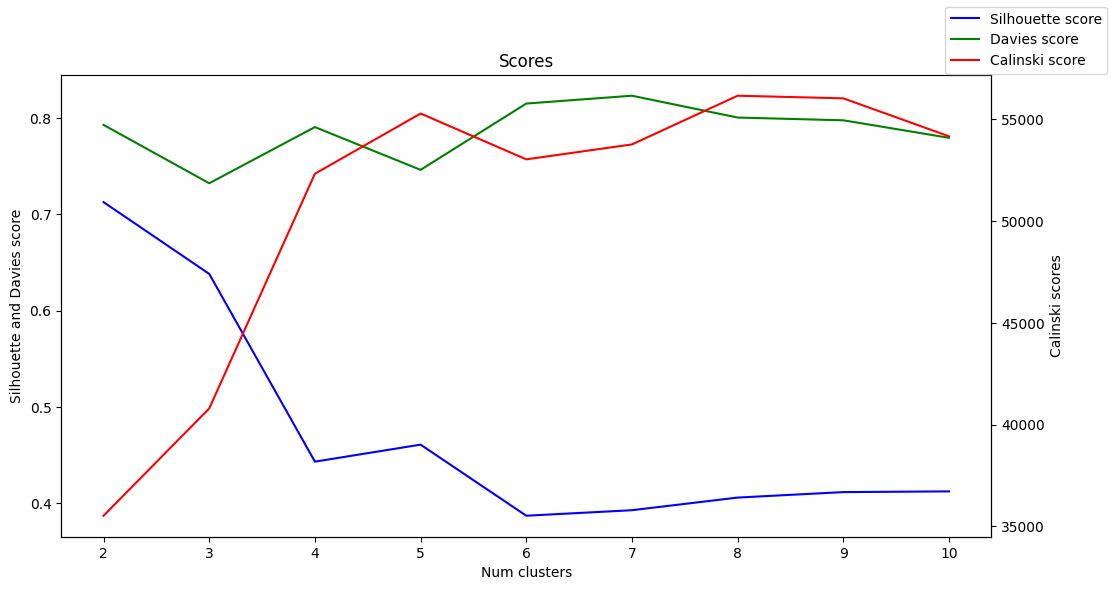

In [ ]:
# plot results of the number of clusters optimization with the scores
fig, ax1 = plt.subplots(figsize=(12, 6))

ax1.plot(num_clusters, scores_silhouette, color='blue', label='Silhouette score')
ax1.plot(num_clusters, scores_davies, color='green', label='Davies score')
ax1.set_ylabel('Silhouette and Davies score')

ax2 = ax1.twinx()

ax2.plot(num_clusters, scores_calinski, color='red', label='Calinski score')
ax2.set_ylabel('Calinski scores')

fig.legend()
ax1.set_title('Scores')
ax1.set_xlabel('Num clusters')

...

explanation

In [ ]:
# segment descriptive labels based on observed RFM and CLV
segment_map = {
    0: "Lost client / Churned", # compró hace tiempo, no frecuente y poco dinero
    1: "Sporadical big customer", # Potential spenders, # not frequent but more value # comprador poco habitual pero con gran gasto de dinero y el mayor en life time value, muy propensos a hacer campañas comerciales (black friday cuadra con meses de recency)   
    2: "New customer", # low recency, frequency and monetary, muy pronto para sacar conclusiones
    3: "Frequent low value", # frequent but low value and CLV
    4: "Sporadical mid customer" # sporadical recency, small frequency 
}

# map labels
df_rfm['segment_label'] = df_rfm['segment'].map(segment_map)

# dataframe with segments and average values of RFM and CLV per segment
grouped = df_rfm.groupby(["segment","segment_label"])[clustering_columns].mean().round(2)
grouped['Size'] = df_rfm.groupby(["segment","segment_label"]).size()

display(grouped)




,,Recency,Frequency,Monetary,CLV,Size
segment,segment_label,,,,,
0,Lost client / Churned,13.11,1.00,100.55,389.44,36899
1,Sporadical big customer,8.29,1.05,1785.88,7004.27,716
2,New customer,4.41,1.00,99.34,384.41,49829
3,Frequent low value,7.51,2.11,241.01,869.38,2876
4,Sporadical mid customer,7.94,1.00,580.27,2233.37,5100


...

conclusion
podemos sacar conclusiones como que quen da dinero y más CLV  son los esporádicos que gastan en productos caros. Los dos CLV mayores son estos. 
la frecuencia en general es muy baja, or lo que los clientes frecuentes tampoco lo son tanto

In [ ]:
# segments distribution by size of customers
df_rfm["segment"].value_counts().sort_index().plot(kind='bar')

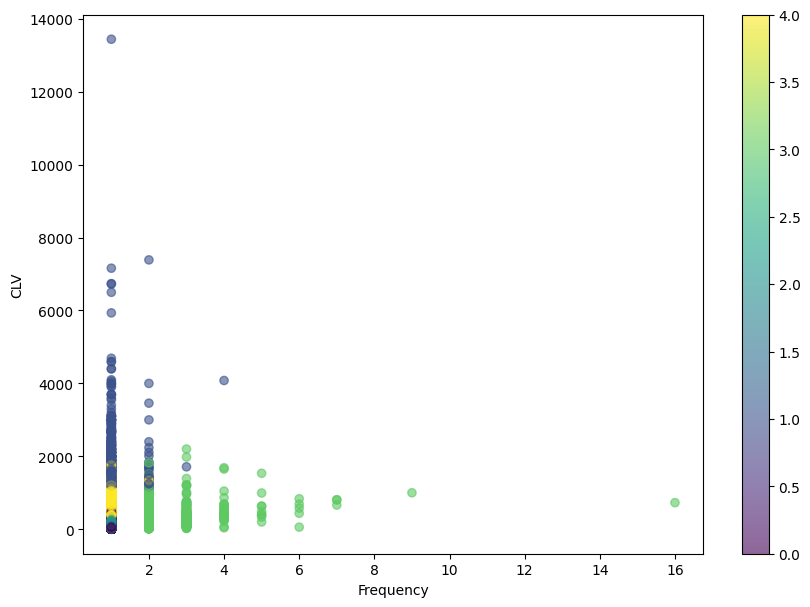

In [326]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111)

scatter = ax.scatter(
    df_rfm['Frequency'], df_rfm['Monetary'],
    c=df_rfm['segment'], alpha=0.6
)

ax.set_xlabel('Frequency')
ax.set_ylabel('CLV')

plt.colorbar(scatter)
plt.show()



## Churn

In [427]:
print(f"Total customers: {len(df_rfm)}")
print(f"Customers with more than one {len(df_rfm[df_rfm['Frequency']>1])}")
print(f"Being a {(len(df_rfm[df_rfm['Frequency']>1]) / len(df_rfm))*100:.1f}%")



Total customers: 95420
Customers with more than one 2913
Being a 3.1%


In [448]:
df

,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,product_category_name,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm,order_purchase,date_limit_churn
0,00010242fe8c5a6d1ba2dd792cb16214,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2017-09-19 09:45:35,58.90,13.29,3ce436f183e68e07877b285a838db11a,delivered,2017-09-13 08:59:02,2017-09-13 09:45:35,2017-09-19 18:34:16,2017-09-20 23:43:48,2017-09-29 00:00:00,871766c5855e863f6eccc05f988b23cb,28013,campos dos goytacazes,RJ,cool_stuff,58.0,598.0,4.0,650.0,28.0,9.0,14.0,2017-09-13,2017-12-12 08:59:02
1,00018f77f2f0320c557190d7a144bdd3,1,e5f2d52b802189ee658865ca93d83a8f,dd7ddc04e1b6c2c614352b383efe2d36,2017-05-03 11:05:13,239.90,19.93,f6dd3ec061db4e3987629fe6b26e5cce,delivered,2017-04-26 10:53:06,2017-04-26 11:05:13,2017-05-04 14:35:00,2017-05-12 16:04:24,2017-05-15 00:00:00,eb28e67c4c0b83846050ddfb8a35d051,15775,santa fe do sul,SP,pet_shop,56.0,239.0,2.0,30000.0,50.0,30.0,40.0,2017-04-26,2017-07-25 10:53:06
2,000229ec398224ef6ca0657da4fc703e,1,c777355d18b72b67abbeef9df44fd0fd,5b51032eddd242adc84c38acab88f23d,2018-01-18 14:48:30,199.00,17.87,6489ae5e4333f3693df5ad4372dab6d3,delivered,2018-01-14 14:33:31,2018-01-14 14:48:30,2018-01-16 12:36:48,2018-01-22 13:19:16,2018-02-05 00:00:00,3818d81c6709e39d06b2738a8d3a2474,35661,para de minas,MG,furniture_decor,59.0,695.0,2.0,3050.0,33.0,13.0,33.0,2018-01-14,2018-04-14 14:33:31
3,00024acbcdf0a6daa1e931b038114c75,1,7634da152a4610f1595efa32f14722fc,9d7a1d34a5052409006425275ba1c2b4,2018-08-15 10:10:18,12.99,12.79,d4eb9395c8c0431ee92fce09860c5a06,delivered,2018-08-08 10:00:35,2018-08-08 10:10:18,2018-08-10 13:28:00,2018-08-14 13:32:39,2018-08-20 00:00:00,af861d436cfc08b2c2ddefd0ba074622,12952,atibaia,SP,perfumery,42.0,480.0,1.0,200.0,16.0,10.0,15.0,2018-08-08,2018-11-06 10:00:35
4,00042b26cf59d7ce69dfabb4e55b4fd9,1,ac6c3623068f30de03045865e4e10089,df560393f3a51e74553ab94004ba5c87,2017-02-13 13:57:51,199.90,18.14,58dbd0b2d70206bf40e62cd34e84d795,delivered,2017-02-04 13:57:51,2017-02-04 14:10:13,2017-02-16 09:46:09,2017-03-01 16:42:31,2017-03-17 00:00:00,64b576fb70d441e8f1b2d7d446e483c5,13226,varzea paulista,SP,garden_tools,59.0,409.0,1.0,3750.0,35.0,40.0,30.0,2017-02-04,2017-05-05 13:57:51
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
112645,fffc94f6ce00a00581880bf54a75a037,1,4aa6014eceb682077f9dc4bffebc05b0,b8bc237ba3788b23da09c0f1f3a3288c,2018-05-02 04:11:01,299.99,43.41,b51593916b4b8e0d6f66f2ae24f2673d,delivered,2018-04-23 13:57:06,2018-04-25 04:11:01,2018-04-25 12:09:00,2018-05-10 22:56:40,2018-05-18 00:00:00,0c9aeda10a71f369396d0c04dce13a64,65077,sao luis,MA,housewares,43.0,1002.0,3.0,10150.0,89.0,15.0,40.0,2018-04-23,2018-07-22 13:57:06
112646,fffcd46ef2263f404302a634eb57f7eb,1,32e07fd915822b0765e448c4dd74c828,f3c38ab652836d21de61fb8314b69182,2018-07-20 04:31:48,350.00,36.53,84c5d4fbaf120aae381fad077416eaa0,delivered,2018-07-14 10:26:46,2018-07-17 04:31:48,2018-07-17 08:05:00,2018-07-23 20:31:55,2018-08-01 00:00:00,0da9fe112eae0c74d3ba1fe16de0988b,81690,curitiba,PR,computers_accessories,31.0,232.0,1.0,8950.0,45.0,26.0,38.0,2018-07-14,2018-10-12 10:26:46
112647,fffce4705a9662cd70adb13d4a31832d,1,72a30483855e2eafc67aee5dc2560482,c3cfdc648177fdbbbb35635a37472c53,2017-10-30 17:14:25,99.90,16.95,29309aa813182aaddc9b259e31b870e6,delivered,2017-10-23 17:07:56,2017-10-24 17:14:25,2017-10-26 15:13:14,2017-10-28 12:22:22,2017-11-10 00:00:00,cd79b407828f02fdbba457111c38e4c4,4039,sao paulo,SP,sports_leisure,43.0,869.0,1.0,967.0,21.0,24.0,19.0,2017-10-23,2018-01-21 17:07:56
112648,fffe18544ffabc95dfada21779c9644f,1,9c42

In [ ]:
max_date_per_client = df[["customer_unique_id", "order_purchase_timestamp"]].groupby("customer_unique_id").max().reset_index()
max_date_per_client = max_date_per_client.rename(columns={"order_purchase_timestamp":"last_order_timestamp"})
max_date_per_client

,customer_unique_id,last_order_timestamp
0,0000366f3b9a7992bf8c76cfdf3221e2,2018-05-10 10:56:27
1,0000b849f77a49e4a4ce2b2a4ca5be3f,2018-05-07 11:11:27
2,0000f46a3911fa3c0805444483337064,2017-03-10 21:05:03
3,0000f6ccb0745a6a4b88665a16c9f078,2017-10-12 20:29:41
4,0004aac84e0df4da2b147fca70cf8255,2017-11-14 19:45:42
...,...,...
95415,fffcf5a5ff07b0908bd4e2dbc735a684,2017-06-08 21:00:36
95416,fffea47cd6d3cc0a88bd621562a9d061,2017-12-10 20:07:56
95417,ffff371b4d645b6ecea244b27531430a,2017-02-07 15:49:16
95418,ffff5962728ec6157033ef9805bacc48,2018-05-02 15:17:41


In [486]:
from datetime import timedelta

days_consider_churn = 150

df_churn = pd.merge(df, max_date_per_client, on="customer_unique_id", how="inner")
df_churn["days_to_buy_next"] = ((df_churn["last_order_timestamp"]  - df_churn["order_purchase_timestamp"]).dt.days).astype(int)
df_churn["churn"] = ((df_churn["days_to_buy_next"]==0) | (df_churn["days_to_buy_next"] > days_consider_churn))
df_churn["target"] = df_churn["churn"].astype(int)
df_churn

                                                                                                           

,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,product_category_name,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm,order_purchase,date_limit_churn,last_order_timestamp,days_to_buy_next,churn,target
0,00010242fe8c5a6d1ba2dd792cb16214,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2017-09-19 09:45:35,58.90,13.29,3ce436f183e68e07877b285a838db11a,delivered,2017-09-13 08:59:02,2017-09-13 09:45:35,2017-09-19 18:34:16,2017-09-20 23:43:48,2017-09-29 00:00:00,871766c5855e863f6eccc05f988b23cb,28013,campos dos goytacazes,RJ,cool_stuff,58.0,598.0,4.0,650.0,28.0,9.0,14.0,2017-09-13,2017-12-12 08:59:02,2017-09-13 08:59:02,0,True,1
1,00018f77f2f0320c557190d7a144bdd3,1,e5f2d52b802189ee658865ca93d83a8f,dd7ddc04e1b6c2c614352b383efe2d36,2017-05-03 11:05:13,239.90,19.93,f6dd3ec061db4e3987629fe6b26e5cce,delivered,2017-04-26 10:53:06,2017-04-26 11:05:13,2017-05-04 14:35:00,2017-05-12 16:04:24,2017-05-15 00:00:00,eb28e67c4c0b83846050ddfb8a35d051,15775,santa fe do sul,SP,pet_shop,56.0,239.0,2.0,30000.0,50.0,30.0,40.0,2017-04-26,2017-07-25 10:53:06,2017-09-18 16:12:04,145,False,0
2,c105be01f21c9df6a2579f59b95cbcd9,1,d2f5484cbffe4ca766301b21ab9246dd,36a968b544695394e4e9d7572688598f,2017-09-22 16:27:55,12.88,11.85,02288a47f696f3054b9ef1d5f8e73973,delivered,2017-09-18 16:12:04,2017-09-18 16:27:55,2017-09-20 20:00:24,2017-09-25 21:59:46,2017-10-04 00:00:00,eb28e67c4c0b83846050ddfb8a35d051,15775,santa fe do sul,SP,computers_accessories,51.0,448.0,1.0,180.0,16.0,9.0,16.0,2017-09-18,2017-12-17 16:12:04,2017-09-18 16:12:04,0,True,1
3,000229ec398224ef6ca0657da4fc703e,1,c777355d18b72b67abbeef9df44fd0fd,5b51032eddd242adc84c38acab88f23d,2018-01-18 14:48:30,199.00,17.87,6489ae5e4333f3693df5ad4372dab6d3,delivered,2018-01-14 14:33:31,2018-01-14 14:48:30,2018-01-16 12:36:48,2018-01-22 13:19:16,2018-02-05 00:00:00,3818d81c6709e39d06b2738a8d3a2474,35661,para de minas,MG,furniture_decor,59.0,695.0,2.0,3050.0,33.0,13.0,33.0,2018-01-14,2018-04-14 14:33:31,2018-01-14 14:33:31,0,True,1
4,00024acbcdf0a6daa1e931b038114c75,1,7634da152a4610f1595efa32f14722fc,9d7a1d34a5052409006425275ba1c2b4,2018-08-15 10:10:18,12.99,12.79,d4eb9395c8c0431ee92fce09860c5a06,delivered,2018-08-08 10:00:35,2018-08-08 10:10:18,2018-08-10 13:28:00,2018-08-14 13:32:39,2018-08-20 00:00:00,af861d436cfc08b2c2ddefd0ba074622,12952,atibaia,SP,perfumery,42.0,480.0,1.0,200.0,16.0,10.0,15.0,2018-08-08,2018-11-06 10:00:35,2018-08-08 10:00:35,0,True,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
112645,fffc94f6ce00a00581880bf54a75a037,1,4aa6014eceb682077f9dc4bffebc05b0,b8bc237ba3788b23da09c0f1f3a3288c,2018-05-02 04:11:01,299.99,43.41,b51593916b4b8e0d6f66f2ae24f2673d,delivered,2018-04-23 13:57:06,2018-04-25 04:11:01,2018-04-25 12:09:00,2018-05-10 22:56:40,2018-05-18 00:00:00,0c9aeda10a71f369396d0c04dce13a64,65077,sao luis,MA,housewares,43.0,1002.0,3.0,10150.0,89.0,15.0,40.0,2018-04-23,2018-07-22 13:57:06,2018-04-23 13:57:06,0,True,1
112646,fffcd46ef2263f404302a634eb57f7eb,1,32e07fd915822b0765e448c4dd74c828,f3c38ab652836d21de61fb8314b69182,2018-07-20 04:31:48,350.00,36.53,84c5d4fbaf120aae381fad077416eaa0,delivered,2018-07-14 10:26:46,2018-07-17 04:31:48,2018-07-17 08:05:00,2018-07-23 20:31:55,2018-08-01 00:00:00,0da9fe112eae0c74d3ba1fe16de0988b,81690,curitiba,PR,computers_accessories,31.0,232.0,1.0,8950.0,45.0,26.0,38.0,2018-07-14,2018-10-12 10:26:46,2018-07-14 10:26:46,0,True,1
112647,fffce4705a9662cd70adb13d4a31832d,1,72a30483855e2eafc67aee5dc2560482,c3cfdc648177fdbbbb35635a37472c53,2017-10-30 17:14:25,99.90,16.95,29309aa813182aaddc9b259e31b870e6,delivered,

<Axes: xlabel='target'>

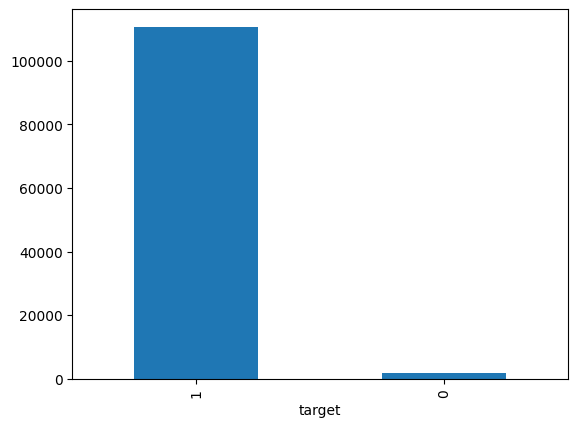

In [492]:
df_churn["target"].value_counts().plot(kind="bar")